In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import ml_helper as mlhelp

#from sklearn.linear_model import LogisticRegression
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.cross_validation import train_test_split
#from sklearn import metrics
#from sklearn.cross_validation import cross_val_score

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

/Library/Python/2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Objective for DataKind Giving Tuesday DataDive

This notebook demonstrates how to normalize charitable donations by median income within each zip code. It is necessary if we want to investigate what proportion of households' income is given to charity. For each ZIP code we did the following adjustment:

\begin{equation*}NormalizedDonation = \frac{\sum_{donations} DonationAmount}{medianHouseholdIncome * NumHouseholds}\end{equation*}

Finally, it adds the converted values into zip code shapefiles provided by the US Census. Resulting map can be seen at: https://zuzanna.carto.com/viz/999bdc1a-01c1-11e7-9bf4-0e3ff518bd15/map

In [3]:
donations_sample = pd.read_csv('donations_sample.csv')

In [4]:
donations_2016 = pd.read_csv("/Users/zuzia/Desktop/DataKind/donations_post_gt_2016.csv")
zips = pd.read_csv("/Users/zuzia/Desktop/DataKind/us_postal_codes_2012.csv")
donations_2016.columns = donations_sample.columns

## Cleaning ZIP codes

In [5]:
def zip_transform(s):  
    """
    this function cleans ZIP code data to make sure it can 
    be merged between data sets
    
    input: str/float/int
    output: str
    
    """
    s = str(s)
        
    if s == 'nan':
        return np.nan
    s = s.lstrip(' ')
    s = s.rstrip(' ')
    s = s.split(".")[0]
    s = s.split("-")[0]
    s = s.split(" ")[0]
    s = s.zfill(5)
    
    if len(s) != 5:
        raise AssertionError()
        
    return s

## Choose only donations smaller than 200 USD

We care about small donations for the #GivingTuesday initiative so it is important to sift through large corporate donations and leave only small ones. I chose 200 USD based on an elbow in a histogram of all donation amounts.

In [6]:
donations_2016.dropna(subset=['DonorZip'], inplace=True)
zips['DonorZip'] = zips['Postal Code']
zips.dropna(subset=['DonorZip'], inplace=True)

# Interested only in small donations, defined as < 200 USD
donations_2016 = donations_2016[donations_2016.DonationAmount < 200]

donations_2016['DonorZip'] = donations_2016['DonorZip'].apply(zip_transform)
zips['DonorZip'] = zips['DonorZip'].apply(zip_transform)

In [8]:
donations_2016.head()

,DonationAmount,DonationDate,DonationTime,DonationType,DonorZip,FirstDonation,IRS_Activity,IRS_Ntee,IRS_Org_Zip,InfAdjAmnt,...,org_postal_code,project_id,project_primary_theme,recurring_count,recurring_id,transaction_id,user_id,volume_bucket,year,zip
2,80.0,2012-12-07,31208.0,NaN,20165,NaN,0,B20,20191-1637,84.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012.0,20165.0
3,50.0,2012-12-15,30922.0,NaN,20165,NaN,560000000,X20Z,20175-8916,52.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012.0,20165.0
4,50.0,2012-12-10,63605.0,NaN,20011,NaN,0,O50,20169-1918,52.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012.0,20011.0
5,100.0,2012-12-19,66067.0,NaN,20166,NaN,0,I44,11201-3631,105.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012.0,20166.0
6,75.0,2012-12-21,66323.0,NaN,20165,NaN,0,A70,75214-0962,78.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012.0,20165.0


## Clean and merge in 2016 demographic data

In [9]:
df_demography = pd.read_csv('/Users/zuzia/Desktop/DataKind/feb2017-zip-demography.csv')
df_demography = df_demography[df_demography['PrimaryRecord'] == 'P']

In [10]:
df_demography['ZipCode'] = df_demography['ZipCode'].apply(zip_transform)
df_income = df_demography[['ZipCode', 'IncomePerHousehold','HouseholdsPerZipCode']]
df_income.columns = ['DonorZip', 'IncomePerHousehold','HouseholdsPerZipCode']

In [11]:
totals_per_zip = donations_2016.groupby(by='DonorZip').sum()['DonationAmount']
totals_per_zip = pd.DataFrame(totals_per_zip)
totals_per_zip['DonorZip'] = totals_per_zip.index

In [12]:
df = pd.merge(totals_per_zip, df_income, on='DonorZip', how='inner')
df = pd.merge(df,
              zips,
              on=['DonorZip'], 
              suffixes=('_donations_sample','_zips'))
df['IncomePerZipcode']=df['IncomePerHousehold'] * df['HouseholdsPerZipCode']
df['DonationAmountPerIncome'] = df['DonationAmount'] / df['IncomePerZipcode']

## Plot normalized donations as a histogram

In [13]:
# Doesn't like infinity
df = df[df['DonationAmountPerIncome']!=np.inf]
df.dropna(inplace=True, subset=['DonationAmountPerIncome'])

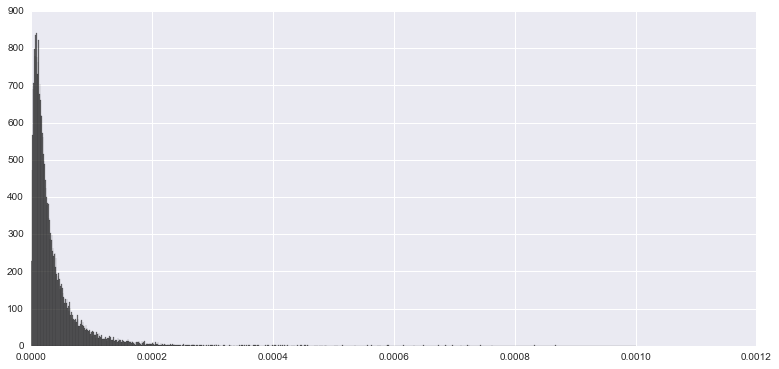

In [14]:
fig = plt.figure(figsize = [13,6])
bins = np.linspace(0,0.001,1000)
df['DonationAmountPerIncome'].hist(color='k', alpha=0.5, bins=bins)

## Save the data frame and import into Carto, for example

In [51]:
df.head()

,DonationAmount,DonorZip,IncomePerHousehold,HouseholdsPerZipCode,Postal Code,Place Name,State,State Abbreviation,County,Latitude,Longitude,Unnamed: 7,IncomePerZipcode,DonationAmountPerIncome
2,15699.76,01001,60161,7215,1001.0,Agawam,Massachusetts,MA,Hampden,42.0702,-72.6227,NaN,434061615,0.000036
3,114674.05,01002,50540,9910,1002.0,Amherst,Massachusetts,MA,Hampshire,42.3671,-72.4646,NaN,500851400,0.000229
6,6216.88,01005,68786,1904,1005.0,Barre,Massachusetts,MA,Worcester,42.4097,-72.1084,NaN,130968544,0.000047
7,32172.70,01007,76881,5595,1007.0,Belchertown,Massachusetts,MA,Hampshire,42.2751,-72.4110,NaN,430149195,0.000075
8,3199.00,01008,70417,503,1008.0,Blandford,Massachusetts,MA,Hampden,42.1829,-72.9361,NaN,35419751,0.000090


In [43]:
df.to_csv("/Users/zuzia/Desktop/DataKind/normalized_less_than_200_donations_2016.csv")

# GeoPandas: displaying within zip code

In [4]:
import geopandas as gpd


In [8]:
donations = gpd.GeoDataFrame.from_file("normalized_less_than_200_donations_2016.geojson") 

zips = gpd.GeoDataFrame.from_file("cb_2015_us_zcta510_500k.geojson") 

donzip = donations.merge(zips, left_on="donorzip", right_on="zcta5ce10", how="outer")


In [ ]:
donzip["geometry"] = donzip["geometry_y"]

donzip  = gpd.GeoDataFrame(donzip)

final = donzip.dissolve(by='donorzip', aggfunc='sum')

final.to_file("donationsbyzip") 
#donzip.to_file("donationsbyzip") 
